In [40]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from simpledbf import Dbf5

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.svm import SVR

import operator 
from ReclassifyLandUse import ReC

import importlib
import DamageEstimation
importlib.reload( DamageEstimation )
from DamageEstimation import DepthDamage

import pickle
from pyogrio import read_dataframe, write_dataframe
from geo_northarrow import add_north_arrow
from  NFIP_calculator import Insurer
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from matplotlib.pylab import cm
from matplotlib.colors import rgb2hex


import warnings
import seaborn as sns
import scipy.stats as stats

warnings.filterwarnings('ignore')

# Read and preprocess data

In [41]:
dictpth    = r'../inputs/saved_neighbor_dict.pkl'
pthSG      = r'../outputs/Safegraph_VisitCount.csv'
pth11      = r"../inputs/Harzus_tool/flBldgStructDmgFn.csv"
pth22      = r"../inputs/Harzus_tool/flBldgContDmgFn.csv"
pth33      = r"../inputs/Harzus_tool/flBldgInvDmgFn.csv"
pthpolicy  = r"../outputs/Policy_Zip.csv"

""" GBDT regression """
def ChangeState( laudcode1, landcode2):
    if landcode2  == 1 and laudcode1  != 1 :
        #residential
        return 1
    elif landcode2  == 2 and laudcode1  != 2 :
        #commercial land
        return 2
    elif landcode2  == 3 and laudcode1  != 3 :
        #industrial land
        return 3
    elif landcode2  == 4 and laudcode1  != 4 :
        #infrastructural land
        return 4
    elif landcode2  == 5 and laudcode1  != 5 :
        #public land
        return 5
    else: 
        return 0

In [42]:
fp = "../inputs/Parcels_tf6_5_area_unique_dist.shp"
Geodata0 = read_dataframe(fp)
print( Geodata0.columns )
Geodata0['TARGET_FID']  = Geodata0['index']
Geodata0                = Geodata0.to_crs({'init':'epsg:4326'})

#Pathpoi = "/Users/yuhan/Desktop/Gradient_Boost_code/inputs/data_export/Parcels_tf6_5_area_unique.shp"
#Geodata0_poi = read_dataframe(Pathpoi)
#print( Geodata0_poi.columns )

Index(['index', 'OBJECTID', 'GEOID', 'ID', 'NAME', 'CITY', 'ST', 'ZIP',
       'SITUS_NO', 'SITUS',
       ...
       'Accessb', 'logAccess', 'release', 'capture_da', 'area_2', 'pararea',
       'NEAR_FID', 'NEAR_DIST', 'NEA_DIST2', 'geometry'],
      dtype='object', length=129)


<Axes: >

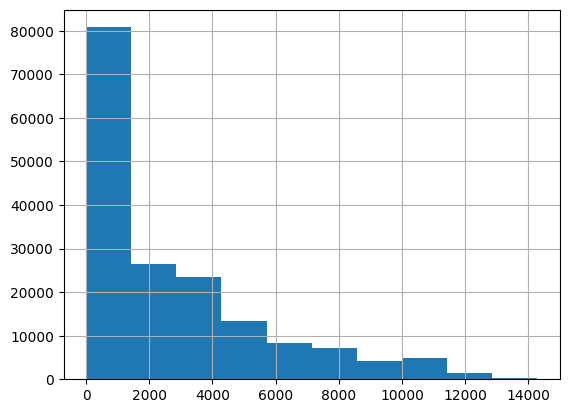

In [43]:
Geodata0.NEAR_DIST.hist()


In [79]:

#fp_cluster = "../inputs/data_export/Parcels_tf6_5_area_unique_clustering.shp"
#fp_cluster = "../inputs/data_export/clusters/Parcels_tf6_5_area_unique_cluster5.shp"

#Geodata_clusters = read_dataframe( fp_cluster )
#print( Geodata_clusters.columns )
#Geodata0.poicode


In [58]:
#print( Geodata_clusters.CLUSTER_ID.unique() )

print( Geodata0.head() )


   index  OBJECTID               GEOID      ID  \
0      0    208101  0055-0029-0000-000  173976   
1      1    207425  0182-0030-0000-000  307794   
2      2    235655  5646-0000-0001-000  720713   
3      3    265804  2805-0000-0038-000  205089   
4      4    201374  0145-0034-0001-000  375911   

                                  NAME       CITY  ST         ZIP SITUS_NO  \
0             WILLIAMS ROENA BACKSTROM    HOUSTON  TX  77004-6525     6421   
1                       CITY-HITCHCOCK  HITCHCOCK  TX  77563-3535     None   
2            SANTIAGO ESTEBAN & AWILDA  DICKINSON  TX  77539-7497     3706   
3  TEMPLETON GARY J & JAN C CULBERTSON  DICKINSON  TX       77539     5001   
4            PALMER ROY DAN & JUDITH A   SANTA FE  TX  77510-9534     None   

                                            SITUS  ...  logAccess release  \
0                  6421 HWY 6 HITCHCOCK, TX 77563  ...   9.229555       2   
1  @N RAILROAD AVE / FAIRWOOD HITCHCOCK, TX 77563  ...   9.229555       2   

In [143]:
#print( Geodata_clusters.CLUSTER_ID.unique() )
#print( Geodata_clusters.head() )

In [144]:
#Geodata0_clusters = pd.merge(Geodata0, Geodata_clusters[ ['SOURCE_ID', 'CLUSTER_ID'] ],
#                               how='left', left_on=['index'], right_on=['SOURCE_ID'])

In [275]:
#Geodata0_clusters.head()

In [52]:
'''
pth2 = '../outputs/Safegraph_VisitCount.csv'
SafeGraph_galvagg = pd.read_csv(pth2,encoding='utf-8')
print( SafeGraph_galvagg.dtypes )
SafeGraph_galvagg['poi_cbg'] = SafeGraph_galvagg['poi_cbg'].astype(str)
Geodata0 = pd.merge(Geodata0, SafeGraph_galvagg, 
                    left_on='CensusBlk', right_on='poi_cbg', how='left')
Geodata0.tail()
'''
#GeoNeighbors[0]

"\npth2 = '../outputs/Safegraph_VisitCount.csv'\nSafeGraph_galvagg = pd.read_csv(pth2,encoding='utf-8')\nprint( SafeGraph_galvagg.dtypes )\nSafeGraph_galvagg['poi_cbg'] = SafeGraph_galvagg['poi_cbg'].astype(str)\nGeodata0 = pd.merge(Geodata0, SafeGraph_galvagg, \n                    left_on='CensusBlk', right_on='poi_cbg', how='left')\nGeodata0.tail()\n"

In [44]:
with open( dictpth, 'rb' ) as f:
    GeoNeighbors = pickle.load(f)

In [45]:
#Geodata0_clusters.CensusBlk.head()
#Geodata = Geodata0_poi
Geodata = Geodata0

In [46]:
Geodata.VAL19TOT        = pd.to_numeric( Geodata.VAL19TOT.replace(',', ''), 
                                            errors='coerce')
Geodata.VAL19LAND       = pd.to_numeric( Geodata.VAL19LAND.replace(',', ''),
                                            errors='coerce')
Geodata.VAL19IMP        = pd.to_numeric( Geodata.VAL19IMP.replace(',', ''),
                                            errors='coerce')
Geodata['VAL19TOT']     =  Geodata['VAL19TOT'].fillna(0)
Geodata['VAL19LAND']    =  Geodata['VAL19LAND'].fillna(0)
Geodata['VAL19IMP']     =  Geodata['VAL19TOT'] -  Geodata['VAL19LAND'] 
Geodata['LANDUSE']      =  Geodata['LANDUSE'].fillna("")
Geodata["lu01re"]       =  Geodata["lu01"].apply(ReC.reclassify)
Geodata["lu06re"]       =  Geodata["lu06"].apply(ReC.reclassify)
Geodata["lu11re"]       =  Geodata["lu11"].apply(ReC.reclassify)
Geodata["lu15re"]       =  Geodata["lu15"].apply(ReC.reclassify)
Geodata["lu20re"]       =  Geodata["lu20"].apply(ReC.reclassify) 

In [47]:
Geodata[ 'landCode' ] =  Geodata["LANDUSE"].apply(ReC.reassignBuildingCode)
Geodata[ 'LUCode' ]   =  Geodata["landCode"].apply(ReC.reassignBuildingCode2)
#Geodata = Geodata.apply(ReC.reassignNonLU,  axis=1)    


In [48]:
Geodata["LUCode01re"] =  Geodata[ 'LUCode' ] 
Geodata["LUCode06re"] =  Geodata[ 'LUCode' ] 
Geodata["LUCode11re"] =  Geodata[ 'LUCode' ] 
Geodata["LUCode15re"] =  Geodata[ 'LUCode' ] 
Geodata["LUCode20re"] =  Geodata[ 'LUCode' ] 


In [49]:
Geodata = Geodata.apply( ReC.reclassify2,  axis=1 )

In [50]:
DamageFunc1 =pd.read_csv(pth11, encoding='utf-8')
DamageFunc2 =pd.read_csv(pth22, encoding='utf-8')
DamageFunc3 =pd.read_csv(pth33, encoding='utf-8')
print ("Finish read data first part")


Finish read data first part


In [51]:
Policy_Zip =pd.read_csv(pthpolicy, encoding='utf-8')
#Policy_Zip.head()

In [52]:
Policy_Zip = Policy_Zip[ ["ZipCode", "policyCost", 
                        "policyCount", "CBR", 
                        "CBRStd", "elevationN"] ]
Policy_Zip["ZipCode"] = pd.to_numeric(Policy_Zip["ZipCode"], 
                                              errors='coerce')

In [53]:
Policy_Zip = Policy_Zip.groupby(['ZipCode']).agg({
                            "policyCost"  : ['sum'], 
                            "policyCount" : ['sum'], 
                            "CBR"         : ['max'], 
                            "CBRStd"      : ['max'], 
                            "elevationN"  : ['sum'] }).reset_index()

In [54]:
Policy_Zip.columns       = ['ZipCode' , 'policyCost', 'policyCount', 
                                    'CBR', 'CBRStd', 'elevationN']
Geodata = Geodata.merge(Policy_Zip, 
                                left_on='ZipCode', 
                                right_on='ZipCode', how='left')

In [55]:
from scipy.stats import truncnorm
Geodata['CBR']     = Geodata['CBR'].fillna(0.386)
Geodata['CBRStd']  = Geodata['CBRStd'].fillna(0.095)
CBR = np.random.normal(loc= Geodata['CBR'], scale= Geodata['CBRStd']).tolist()
CBRlist = []
for idx in range( len( CBR ) ) :
    cbi = CBR[idx]
    if cbi < 0:
        cbi2 = truncnorm.rvs(0, 1, loc= Geodata['CBR'][idx], 
                                     scale= Geodata['CBRStd'][idx], size=1)
        #print(cbi2)
        CBRlist.append( cbi2[0] )
    elif cbi > 1:
        cbi2 = truncnorm.rvs(0, 1, size=1)
        #print(cbi2)
        CBRlist.append( cbi2[0] )
    else:
        CBRlist.append( cbi )


In [56]:
A1 = DamageFunc1.loc[ DamageFunc1.Description == 'one floor, no basement, Structure, A-Zone' ].reset_index().loc[0].tolist()[5:34]
V1 = DamageFunc1.loc[ DamageFunc1.Description == 'one floor, no basement, Structure, V-Zone' ].reset_index().loc[0].tolist()[5:34]
O1 = DamageFunc1.loc[ DamageFunc1.Description == 'one story, no basement, Structure' ].reset_index().loc[0].tolist()[5:34]
inundation      = list( range(-4, 25 ) )
A1inundation    = dict(zip(inundation, A1))
V1inundation    = dict(zip(inundation, V1))
O1inundation    = dict(zip(inundation, O1))

In [57]:
DatamagEstimator       = DepthDamage( DamageFunc1, DamageFunc2, DamageFunc3)

Geodata['Content_Build_R']  = CBRlist
Geodata["ACRES" ]           = pd.to_numeric(Geodata.ACRES.replace(',',''), errors='coerce')
Geodata["ACRES" ]           = Geodata["ACRES" ].fillna(0)
#2.68
#2.97
#3.18
#3.39
#3.61
Geodata["Cate1" ]           = Geodata.apply(lambda x: DatamagEstimator.catedepth(x['Cate1'], 2.68), axis=1)
Geodata["Cate2" ]           = Geodata.apply(lambda x: DatamagEstimator.catedepth(x['Cate2'], 2.97), axis=1)
Geodata["Cate3" ]           = Geodata.apply(lambda x: DatamagEstimator.catedepth(x['Cate3'], 3.18), axis=1)
Geodata["Cate4" ]           = Geodata.apply(lambda x: DatamagEstimator.catedepth(x['Cate4'], 3.39), axis=1)
Geodata["Cate5" ]           = Geodata.apply(lambda x: DatamagEstimator.catedepth(x['Cate5'], 3.61), axis=1)
#################################################
Geodata["Cost"]             = Geodata["VAL19TOT"]
Geodata["NumStories"]       = Geodata["N_Storie"]  
Geodata["FoundationType"]   = Geodata["Foundation"]
#Geodata["FirstFloorHt"]     = DatamagEstimator.f( Geodata["DEM"] ) 
Geodata["FirstFloorHt"]     = 0

Geodata["Area"]             = Geodata["Bldg_Area"]
Geodata["ContentCost"]      = Geodata["VAL19TOT"] * Geodata['Content_Build_R']
Geodata["BldgDamageFnID"]   = 213
Geodata["CDDF_ID"]          = 29
Geodata["YEARBUILT"]        = Geodata["Year_Built"] 
Geodata["Tract"]            = Geodata["CensusBlk"] 
Geodata["Latitude"]         = Geodata["Lati"]
Geodata["Longitude"]        = Geodata["Long"]
floodzoneids                = Geodata.floodzones.astype(int).tolist()
print ("Finish read data second part")

def PerceivedRisk( income, moel3_slr03, moel2_slr03, moel1_slr03 ):
    if income <= 3:
        return moel1_slr03
    elif income > 3 and income < 8:
        return moel2_slr03
    else:
        return moel3_slr03

Finish read data second part
Finish read data second part


In [58]:
InsCal = Insurer()
results1 = []
for index, row in Geodata.iterrows():
    if row["VAL19IMP"] > 0:
        inscost = InsCal.insuranceCost( row['VAL19IMP'], 
                             row['ContentCost'], 
                             row['floodzones'], 
                             row['FirstFloorHt'] ,
                             row['Cate4'] )[1]
        results1.append( inscost )
    else:
        results1.append( 0 )
# Geodata.loc[ Geodata["rank"] < lengthi, "VAL19IMP"] = Geodata.loc[ Geodata["rank"] < lengthi, "ImproVal"]
Geodata['Insurance']      = results1

In [20]:
print( Geodata.Cate5.unique()  )
print( Geodata.floodzones.unique() )

[13. 14.  0. 20. 10.  8. 99. 16. 17.  2.  3. 15.  9. 12.  6. 18. 19.  1.
 11.  7.  4.  5. 21.]
[  3  11   8  10   5   1   6 128]


In [59]:
def neghbor_prob( indx, Geodata, GeoNeighbors, luc_col_name):
    nni = len( GeoNeighbors[ indx ]  )
    neighbor_probs = np.zeros( 5 ) 
    if nni > 0:
        subframei = Geodata[ Geodata['index'].isin( GeoNeighbors[indx]  ) ]
        sub_landuse_count = subframei[[luc_col_name]].value_counts()
        print( sub_landuse_count )
        if 1 in sub_landuse_count:
            neighbor_probs[0] = sub_landuse_count[1] * 1.0 / nni
        if 2 in sub_landuse_count:
            neighbor_probs[1] = sub_landuse_count[2] * 1.0 / nni
        if 3 in sub_landuse_count:
            neighbor_probs[2] = sub_landuse_count[3] * 1.0 / nni
        if 4 in sub_landuse_count:
            neighbor_probs[3] = sub_landuse_count[4] * 1.0 / nni
        if 5 in sub_landuse_count:
            neighbor_probs[4] = sub_landuse_count[5] * 1.0 / nni
    return np.argmax(  neighbor_probs )

#Geodata_dict = Geodata.to_dict('records')

neghbor_prob( 2201, Geodata, GeoNeighbors, 'LUCode11re') 

LUCode11re
7             24
1              5
6              1
Name: count, dtype: int64


0

In [60]:
print ("Finish read data third part")

urban_neighbor1 = np.zeros( len(GeoNeighbors) ) 
urban_neighbor2 = np.zeros( len(GeoNeighbors) ) 
urban_neighbor3 = np.zeros( len(GeoNeighbors) ) 
urban_neighbor4 = np.zeros( len(GeoNeighbors) ) 
urban_neighbor5 = np.zeros( len(GeoNeighbors) ) 

Geodata_dict = Geodata.to_dict('records')
count_id = 0
for row in Geodata_dict:
    fidi        = row['index']
    if fidi in GeoNeighbors:
        nni = len( GeoNeighbors[fidi]  )
        if nni > 0:
            subframei = Geodata[ Geodata['index'].isin( GeoNeighbors[fidi]  ) ]
            sub_landuse_count = subframei.LUCode20re.value_counts()
            if 1 in sub_landuse_count:
                urban_neighbor1[count_id] = sub_landuse_count[1] * 1.0 / nni
            if 2 in sub_landuse_count:
                urban_neighbor2[count_id] = sub_landuse_count[2] * 1.0 / nni
            if 3 in sub_landuse_count:
                urban_neighbor3[count_id] = sub_landuse_count[3] * 1.0 / nni
            if 4 in sub_landuse_count:
                urban_neighbor4[count_id] = sub_landuse_count[4] * 1.0 / nni
            if 5 in sub_landuse_count:
                urban_neighbor5[count_id] = sub_landuse_count[5] * 1.0 / nni
        else:
            urban_neighbor1[count_id] = 0 
            urban_neighbor2[count_id] = 0 
            urban_neighbor3[count_id] = 0 
            urban_neighbor4[count_id] = 0 
            urban_neighbor5[count_id] = 0 
    else:
        urban_neighbor1[count_id] = 0 
        urban_neighbor2[count_id] = 0 
        urban_neighbor3[count_id] = 0 
        urban_neighbor4[count_id] = 0 
        urban_neighbor5[count_id] = 0 
    count_id = count_id + 1
    if fidi % 20000 == 0:
        print( fidi )

Geodata['NN1'] = urban_neighbor1
print ("Finish land use 1")
###########################################################################
Geodata['NN2'] = urban_neighbor2
print ("Finish land use 2")
###########################################################################
Geodata['NN3'] = urban_neighbor3
print ("Finish land use 3")
###########################################################################
Geodata['NN4'] = urban_neighbor4
print ("Finish land use 4")
###########################################################################
Geodata['NN5'] = urban_neighbor5
print ("Finish land use 5")

Finish read data third part
0
20000
40000
60000
80000
100000
120000
140000
160000
Finish land use 1
Finish land use 2
Finish land use 3
Finish land use 4
Finish land use 5


(array([14853.,  4904.,  6800.,  3949.,  6607., 10899., 10153.,  8943.,
        21526., 81560.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

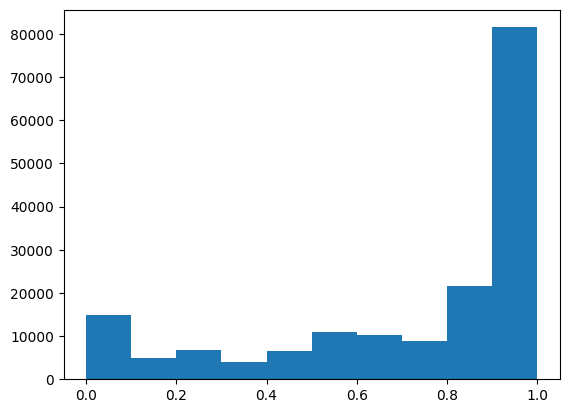

In [21]:
plt.hist( urban_neighbor1 )

In [61]:
print (Geodata['NN1'].value_counts() )
print("###############################")
print (Geodata['NN2'].value_counts() )
print("###############################")
print (Geodata['NN3'].value_counts() )
print("###############################")
print (Geodata['NN4'].value_counts() )
print("###############################")
print (Geodata['NN5'].value_counts() )
print("###############################")


NN1
1.000000    37363
0.966667    18744
0.933333    14441
0.900000    11012
0.866667     8861
            ...  
0.607143        1
0.736842        1
0.687500        1
0.411765        1
0.880000        1
Name: count, Length: 208, dtype: int64
###############################
NN2
0.000000    126719
0.033333     15797
0.066667      7098
0.100000      3887
0.133333      2742
             ...  
0.240000         1
0.560000         1
0.357143         1
0.304348         1
0.458333         1
Name: count, Length: 189, dtype: int64
###############################
NN3
0.000000    169259
0.033333       418
0.066667       102
0.100000        38
0.200000        31
             ...  
0.705882         1
0.052632         1
0.076923         1
0.086957         1
0.321429         1
Name: count, Length: 115, dtype: int64
###############################
NN4
0.000000    125030
0.033333     20478
0.066667     10157
0.100000      4875
0.133333      2558
             ...  
0.321429         1
0.588235         1
0.3

In [62]:
print( Geodata.NEAR_DIST.max() )
Geodata.NEA_DIST2.head()

14277.1962532


0     951.610652
1    1113.475876
2    2212.199557
3       1.538221
4     480.094784
Name: NEA_DIST2, dtype: float64

In [63]:
#print(Geodata.columns[-60:-1], sep = "\n")
#Geodata.PopWhite
Geodata["WaterCoastDist"] = Geodata.apply(lambda x: x['NEAR_DIST'] if x['NEAR_DIST'] < x['NEA_DIST2'] else x['NEA_DIST2'] , axis=1)

<Axes: >

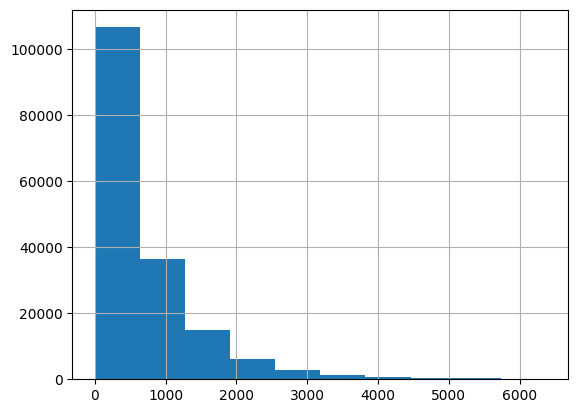

In [123]:
Geodata["WaterCoastDist"].hist()

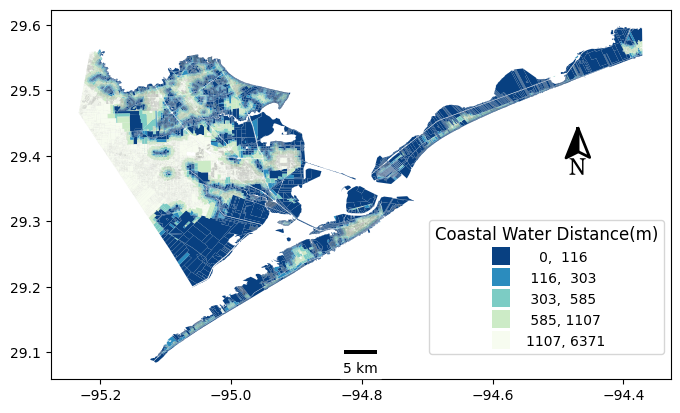

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
pmarks = []
divider = make_axes_locatable(ax)
Geodata.plot(column='WaterCoastDist', scheme="Quantiles", k = 5,
           legend=True,
           ax=ax, cmap='GnBu_r',     
           edgecolor="gray",  # Borderline color
           linewidth=0.01,
           
           legend_kwds={'loc':'upper right', 
                        'bbox_to_anchor':(1.0, 0.45), 
                        'fmt':'{:.0f}',
                        'markerscale':1.26, 
                        'title_fontsize':'large', 
                        'fontsize':'medium'}
           )

leg1 = ax.get_legend()
# Set markers to square shape
for ea in leg1.legendHandles:
    ea.set_marker('s')
leg1.set_title("Coastal Water Distance(m)")

x, y, arrow_length = 0.85, 0.6, 0.12
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction = 0.1) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()

In [29]:

'''
               return value     lower ci     upper ci
return period                                        
10.0            2650.643423  2567.506336  2746.176299
25.0            2899.025313  2707.166097  3165.511734
50.0            3143.795993  2814.983681  3635.843021
100.0           3451.614502  2922.078413  4336.500796
200.0           3838.720651  3017.764038  5355.294631
'''


'\n               return value     lower ci     upper ci\nreturn period                                        \n10.0            2650.643423  2567.506336  2746.176299\n25.0            2899.025313  2707.166097  3165.511734\n50.0            3143.795993  2814.983681  3635.843021\n100.0           3451.614502  2922.078413  4336.500796\n200.0           3838.720651  3017.764038  5355.294631\n'

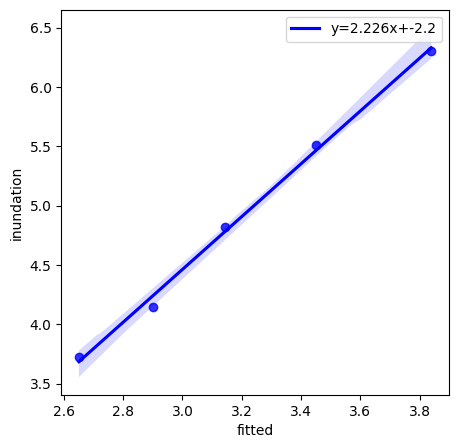

In [79]:
from scipy import stats

x = [2650.643423, 2899.025313, 3143.795993, 3451.614502, 3838.720651	]
y = [   Geodata["Cate1"].mean() * 0.3048, 
        Geodata["Cate2"].mean() * 0.3048, 
        Geodata["Cate3"].mean() * 0.3048, 
        Geodata["Cate4"].mean() * 0.3048, 
        Geodata["Cate5"].mean() * 0.3048 ]

totalmean = pd.DataFrame()
totalmean['fitted'] = np.divide( x, 1000.0 )
totalmean['inundation'] = y


fig, ax = plt.subplots(figsize=(5, 5))

#sns.lineplot(data=df2, x='x', y='y2', label='b', ax=ax)
slope, intercept, r_value, p_value, std_err = stats.linregress(totalmean['fitted'],
                                                               totalmean['inundation'])
p = sns.regplot( data= totalmean, 
            x = "fitted", y = "inundation", ax = ax, color='b', 
 line_kws={'label':"y={0:.3f}x+{1:.1f}".format(slope,intercept)})


# plot legend
p.legend()
plt.show()


In [80]:
print( "Return period 100 year {}, {}".format( 
    1 / (1 - np.exp( -1* np.exp( -1*( 3607.831587 - 1995.194 ) / 304.512 ) ) ) ,
    (1 - np.exp( -1* np.exp( -1*( 3607.831587 - 1995.194 - 200 ) / 304.512 ) ) ) ) )                   

# (1 - np.exp( -1* np.exp( -1*( 3607.831587 - 1995.194 - 200 ) / 304.512 ) ) ) 
# name: gumbel_r                              
# free parameters: loc, scale                 
# fixed parameters: all parameters are free   
# MLE parameters: loc=1,995.194, scale=304.512

Return period 100 year 199.9995019945773, 0.009620579626297254


In [82]:
rand_unif = stats.uniform.rvs(loc= 0, scale= 1, size=1000)

rand_heights = -1 * np.log( -1 * np.log(1 - rand_unif )   ) * 304.512 + 1995.194
print( np.min(rand_heights) )
print( np.max(rand_heights) )

1349.0932713306333
3924.8848627140933


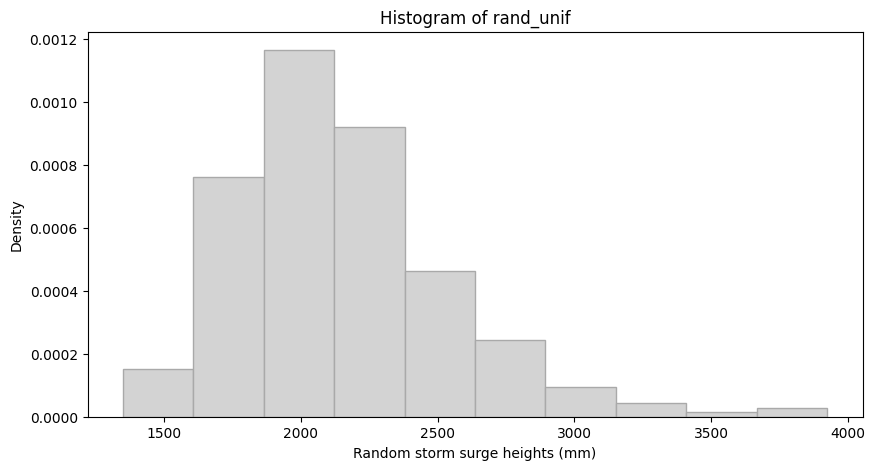

In [83]:
plt.figure(figsize=(10, 5))
plt.hist(rand_heights, density=True, color="lightgrey", edgecolor="darkgrey")
plt.xlabel("Random storm surge heights (mm)")
plt.ylabel("Density")
plt.title('Histogram of rand_unif')
plt.show()


In [84]:
#Geodata.buildDEM
# -1* ln( -1* ln(y) ) * beta + mu
Geodata[ [ "DEM", "DEMmhw", "buildDEM", "FirstFloorHt"]].head()

,DEM,DEMmhw,buildDEM,FirstFloorHt
0,8.22671,8.26052,2.92,4.492186
1,8.34096,8.41053,43.45,4.477001
2,30.50020,30.73580,16.38,1.531812
3,4.25198,4.39834,21.83,5.020468
4,15.27690,15.27000,7.34,3.555144


<Axes: >

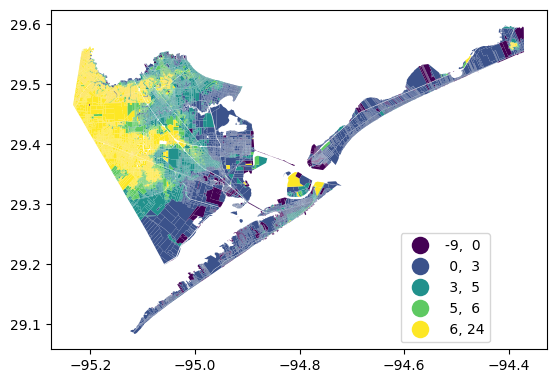

In [168]:

Geodata['DEMm'] = Geodata['DEM'] * 0.3048
Geodata.plot(column='DEMm', 
            #scheme="Quantiles", k = 5,
            scheme="user_defined", k = 5,
            classification_kwds={'bins':[0, 3, 5, 6]},
            legend=True, linewidth=0.01,
            legend_kwds={'loc':'lower right', 
                        'bbox_to_anchor':(0.9, 0.0), 
                        'fmt':'{:.0f}',
                        'markerscale':1.26, 
                        'title_fontsize':'large', 
                        'fontsize':'medium'} )


<Axes: >

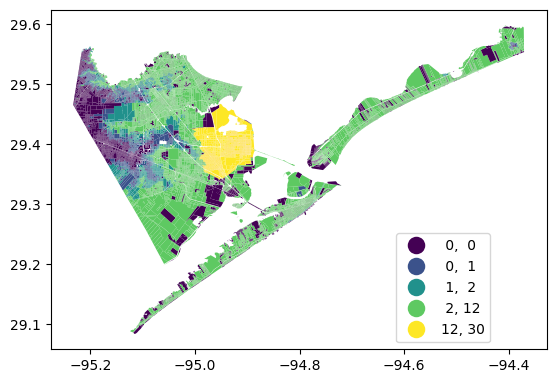

In [32]:
Geodata['Cate5m'] = Geodata['Cate5'] * 0.3048
Geodata['Cate5_flood'] = Geodata.apply(lambda x: x['Cate5m']+ 0.5 - x['FirstFloorHt'] if x['Cate5m'] > x['FirstFloorHt'] else 0, axis=1)

Geodata.plot(column= 'Cate5m', 
             #scheme="Quantiles", k = 5,
            scheme = "user_defined", k = 5,
            classification_kwds = {'bins':[0, 1, 2, 12]},
            legend = True, linewidth = 0.01,
            legend_kwds = { 'loc':'lower right', 
                            'bbox_to_anchor':(0.9, 0.0), 
                            'fmt':'{:.0f}',
                            'markerscale':1.26, 
                            'title_fontsize':'large', 
                            'fontsize':'medium'} )

In [151]:
Geodata.FirstFloorHt

Index(['index', 'OBJECTID', 'GEOID', 'ID', 'NAME', 'CITY', 'ST', 'ZIP',
       'SITUS_NO', 'SITUS',
       ...
       'cate1diff', 'cate2diff', 'cate3diff', 'cate4diff', 'cate5diff',
       'flood5', 'ImpValCat', 'risk_20', 'ImpValColor', 'Cate3m'],
      dtype='object', length=184)

In [25]:
Geodata['VAL19IMP']= Geodata['VAL19IMP'].fillna(0)
#Geodata['ImpValCat'].unique()
#len(cmap)
Geodata['VAL19IMP'].quantile( [0.25, 0.5, 0.75, 1 ])

0.25            0.0
0.50       110040.0
0.75       204670.0
1.00    267928450.0
Name: VAL19IMP, dtype: float64

['0 - 100', '200 - 300', '0 - 0', 'Above 300', '100 - 200']
Categories (5, object): ['0 - 0' < '0 - 100' < '100 - 200' < '200 - 300' < 'Above 300']
0 - 0
0 - 100
100 - 200
200 - 300
Above 300


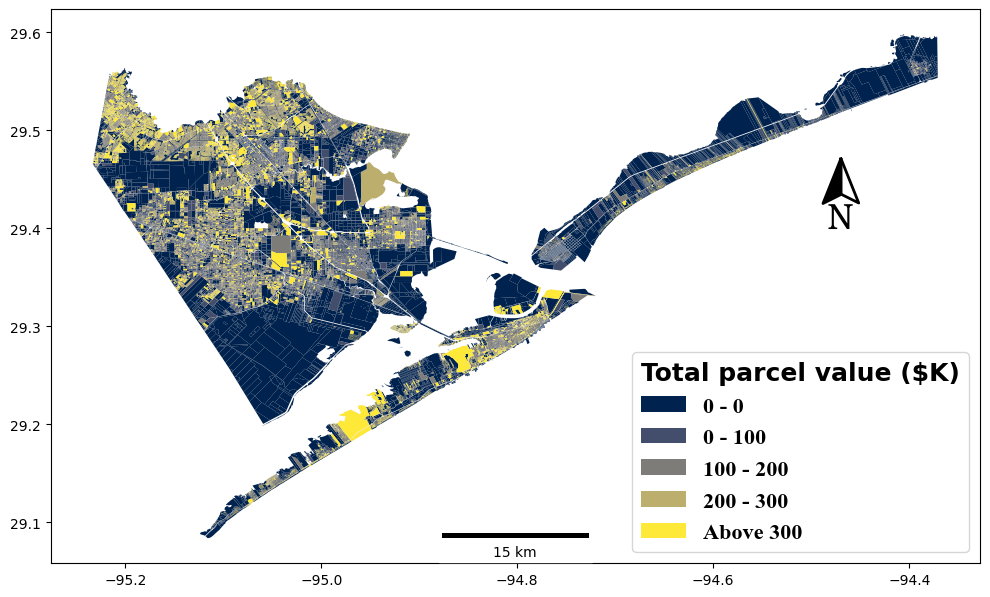

In [122]:
cmap = cm.get_cmap('cividis', 5)
#Geodata[ 'risk_20' ] = Geodata[ 'Risk' ] *  Geodata[ 'VAL19IMP' ]
#Geodata['VAL19TOT'] = Geodata['VAL19TOT'].astype(float)
Geodata['VAL19IMP'] = Geodata['VAL19IMP'].astype(float)
bins = [Geodata['VAL19IMP'].min()-1, 0, 1.0e5, 2e5, 3e5, Geodata['VAL19IMP'].max() + 1]  # Adjust these values based on your data range
Geodata['ImpValCat'] = pd.cut( Geodata['VAL19IMP'], bins, 
                               labels=['0 - 0', '0 - 100',  '100 - 200',  '200 - 300', 
                                       'Above 300'] )
#VAL19IMP, Geodata['VAL19TOT']
#cmap = cm.get_cmap('bwr', 4)
#rgb2hex(cmap(1))
#color_map = {'0 - 100': 'lightgrey', '100 - 150': 'Violet', 
#             '150 - 250': 'Orchid', 
#             'Above 250': 'Fuchsia' }

color_map = { '0 - 0'  : rgb2hex(cmap(0)),   '0 - 100': rgb2hex(cmap(1)), 
              '100 - 200': rgb2hex(cmap(2)), '200 - 300': rgb2hex(cmap(3)),
              'Above 300': rgb2hex(cmap(4))  }
Geodata['ImpValColor'] = Geodata['ImpValCat'].map(color_map)

print( Geodata['ImpValCat'].unique() )
fig, ax = plt.subplots( figsize=(10, 8)  )
pmarks = []
for category, color in color_map.items():
        labeli = category
        print(category)
        Geodata[ Geodata['ImpValCat'] == category ].plot( column='ImpValCat', 
            #scheme="Quantiles", k = 5,
            color = color, edgecolor = 'black',
            linewidth = 0.01, aspect=1,
            ax = ax )
        pmarks.append(Patch(facecolor=color, label=labeli))

#ax.legend(title='Building improvement\nvalue (Thousand$)')

handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="Building improvement\nvalue ($K)",
            title_fontsize= 'xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon= True )

legend = ax.get_legend()
legend.set_title( "Total parcel value ($K)" , prop={'size' : 18, 'weight':'bold'})
leg._legend_box.align = "left"
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist( ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
plt.tight_layout()
#plt.savefig('../output_images/Risk_test0.png',dpi=900, bbox_inches='tight', pad_inches=0)

plt.show()


In [27]:
#Geodata['ImpValColor'].unique(),  
#Geodata.loc[ Geodata['ImpValColor'].isna() ].VAL19TOT

In [64]:

results_risk    = []
updateddem      = []
updateddist     = []
firstfloor      = []
sigmai          = 304.512
mui             = 1995.194
DatamagEstimator       = DepthDamage( DamageFunc1, DamageFunc2, DamageFunc3)

for rowi0 in Geodata.itertuples():
    cateheigs    = np.array( [  rowi0.Cate1, rowi0.Cate2, rowi0.Cate3, 
                                rowi0.Cate4, rowi0.Cate5 ]) 
    counti = 0
    if rowi0.FirstFloorHt  < 0:
        FirstFloori =  0
    else:
        FirstFloori = rowi0.FirstFloorHt
    ffh = FirstFloori
    '''
    if FirstFloori > 3:
        ffh = FirstFloori - 1
    else:
        ffh = FirstFloori
    '''
    firstfloor.append( FirstFloori )
    #elif cate_heightsi < rowi0.Cate4 and rowi0.Cate4 < 22:
    #    diff =  cate_heightsi - rowi0.Cate4
    #    demi = demi + diff
    #rowi0.CoastDist > 4000 and 
    if rowi0.floodzones in [3, 5, 6, 8] :
        if rowi0.NEA_DIST2 < 4000:
            disti = rowi0.NEA_DIST2
        else:
            disti = rowi0.NEAR_DIST
    else:
        disti = rowi0.CoastDist
    
    risk_test = DatamagEstimator.RiskCalculation( ffh  , rowi0.floodzones, 
                                 2020, 2050, disti, rowi0.DEM , cateheigs )
    #print( "Results are {}, {}, {}".format(rowi.floodzones, rowi.WaterCoast, risk_test) )
    results_risk.append(risk_test)
    updateddist.append(disti)

#plt.hist(results_risk)
Geodata['Risk']             = results_risk
Geodata['WaterCoastDist']   = updateddist
Geodata['FirstFloorHt']     = firstfloor


Finish read data second part


<Axes: >

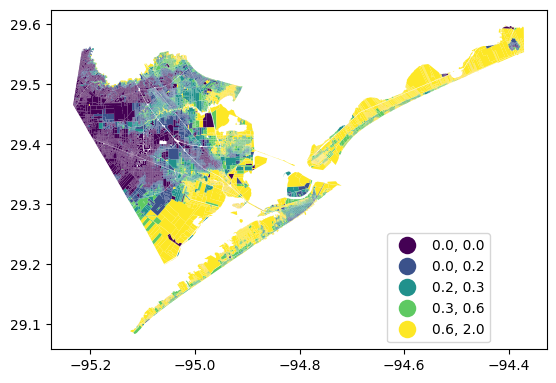

In [126]:
Geodata.plot(column= 'Risk', 
             scheme="Quantiles", k = 5,
            #scheme = "user_defined", k = 5,
            #classification_kwds = {'bins':[0, 1, 2, 12]},
             legend = True, linewidth = 0.0,
             legend_kwds = { 'loc':'lower right', 
                            'bbox_to_anchor':(0.9, 0.0), 
                            'fmt':'{:.1f}',
                            'markerscale': 1.26, 
                            'title_fontsize':'large', 
                            'fontsize':'medium'} )


# Save scenario inputs to shapefiles

# Select data for training

In [51]:

Geodata_select = Geodata[ [ 'PopTot', 'TotalUnit', 'Mobile', 'vacant',
                            'MedHHInc', 'TotAge65', 'BelowHigh', 'BelPoverty',
                            'Minority', 'PopWhite', 'DEM', 'Cate4', 'BeachDist',
                            'HealthDist', 'ParkDist', 'SchoolDist', 'CoastDist',
                            'WetlatDist', 'slope_mhw', 'logAccess', 'area_2',
                            'pararea', 'Risk',
                            'NN1', 'NN2', 'NN2', 'NN4', 'NN5' ] ] 


In [50]:
#Geodata['NewGrowth'] = Geodata.apply( ChangeState , axis=1)
#X_train, X_test, y_train, y_test = train_test_split(Geodata_select, Geodata['NewGrowth'], 
#                                                            test_size=0.4, random_state=0)
#model training started

In [52]:
Geodata['NewGrowth2'] = Geodata.apply( lambda x :
                                      ChangeState( x['LUCode11re'], 
                                                  x['LUCode20re']) , 
                                      axis=1)
Geodata['NewGrowth1'] = Geodata.apply( lambda x :
                                          ChangeState( x['LUCode01re'], 
                                                      x['LUCode11re']) , 
                                          axis=1)
print ( Geodata['NewGrowth1'].value_counts() )

NewGrowth1
0    157250
1     12563
4       178
2       164
5        32
3         7
Name: count, dtype: int64


# Train the gradient boost decision tree

In [50]:
X_train, X_test, y_train, y_test = train_test_split(Geodata_select, 
                                                    Geodata['NewGrowth1'], 
                                                    test_size=0.4, 
                                                    random_state=0)


In [51]:
# # #model training started
n_estimators1 = 400
weak_learner = DecisionTreeClassifier(max_depth= 10)

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth= 10), 
                              learning_rate = 0.25, 
                              n_estimators  = n_estimators1)
ada_clf.fit(X_train, y_train)


#𝑇𝑖+1(𝑥)=𝑇𝑖(𝑥)+𝛼𝑀(𝑥)
#𝑀(𝑥)=∑𝑗=1𝐽𝑡(𝑥,𝜃𝑗)
#This parameter controls how much I'm going to contribute with the 
# new model to the existing one. Normally there is trade off between the number of iterations 𝐾
# and the value of 𝛼. In other words, when taking smaller values of alpha (𝛼≈0) 
# you should consider more 𝐾 iterations, so that your base model (the weak classifier) 
# continues to improve.


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                   learning_rate=0.25, n_estimators=400)

In [52]:

y_predict = ada_clf.predict( X_test )
cm1 = confusion_matrix( y_test, y_predict)
print( 1 - (cm1[0, 1] + cm1[1, 0] ) / (cm1[0, 0] + cm1[1, 1] ) )


0.9717781007751938


In [53]:
with open('../outputs/ada_clf1.pickle', 'wb') as f1:
    pickle.dump(ada_clf, f1)

In [59]:
'''n_estimators2 = 500
ada_clf2 = AdaBoostClassifier( DecisionTreeClassifier(max_depth= 8), 
                              n_estimators= n_estimators2 )
ada_clf2.fit( X_train, y_train )
#model training finished'''

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=8),
                   n_estimators=500)

In [60]:
'''
y_predict2 = ada_clf2.predict( X_test )
cm2 = confusion_matrix( y_test, y_predict2)
print( 1 - (cm2[0, 1] + cm2[1, 0] ) / (cm2[0, 0] + cm2[1, 1] ) )
'''

0.9573680897772456


In [54]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
n_estimators1 = 400

dummy_clf = DummyClassifier()


In [55]:
def misclassification_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)


In [56]:
weak_learner = DecisionTreeClassifier(max_depth= 8)
weak_learners_misclassification_error = misclassification_error(
    y_test, weak_learner.fit(X_train, y_train).predict(X_test)
)


In [57]:
dummy_classifiers_misclassification_error = misclassification_error(
    y_test, dummy_clf.fit(X_train, y_train).predict(X_test)
)

In [58]:

boosting_errors = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators1 + 1),
        "AdaBoost": [
            misclassification_error(y_test, y_pred)
            for y_pred in ada_clf.staged_predict(X_test)
        ],
    } 
).set_index("Number of trees")



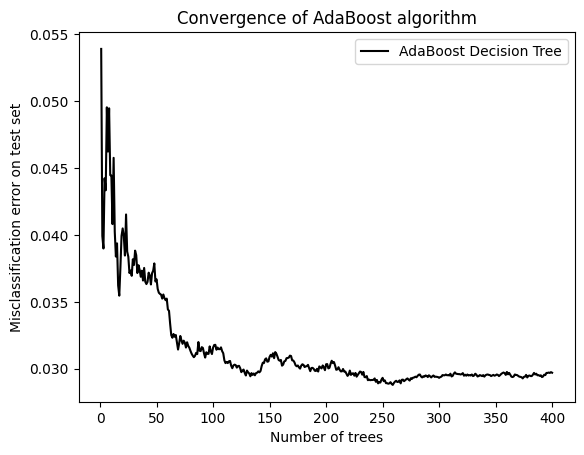

In [59]:
ax = boosting_errors.plot( color="k" )
ax.set_ylabel("Misclassification error on test set")
ax.set_title("Convergence of AdaBoost algorithm")

plt.plot(
    #[boosting_errors.index.min(), boosting_errors.index.max()],
    #[weak_learners_misclassification_error, weak_learners_misclassification_error],
    color="tab:orange",
    linestyle="dashed",
)
plt.plot(
    #[boosting_errors.index.min(), boosting_errors.index.max()],
    #[
    #    dummy_classifiers_misclassification_error,
    #    dummy_classifiers_misclassification_error,
    #],
    color="c",
    linestyle="dotted",
)
plt.legend(["AdaBoost Decision Tree", "DecisionTreeClassifier", "DummyClassifier"], loc= 1)
plt.show()

In [74]:
#with open('../outputs/ada_clf2.pickle', 'wb') as f2:
#    pickle.dump(ada_clf2, f2)

In [60]:
dummy_classifiers_misclassification_error


0.07608919180939511

# Load data for prediction

In [65]:
with open('../outputs/ada_clf1.pickle', 'rb') as f:
     ada_clf = pickle.load(f)


In [66]:

Geodata_select = Geodata[ [ 'PopTot', 'TotalUnit', 'Mobile', 'vacant',
                            'MedHHInc', 'TotAge65', 'BelowHigh', 'BelPoverty',
                            'Minority', 'PopWhite', 'DEM', 'Cate4', 'BeachDist',
                            'HealthDist', 'ParkDist', 'SchoolDist', 'CoastDist',
                            'WetlatDist', 'slope_mhw', 'logAccess', 'area_2',
                            'pararea', 'Risk',
                            'NN1', 'NN2', 'NN2', 'NN4', 'NN5' ] ]

predictions              = ada_clf.predict(Geodata_select)
predictions_probs        = ada_clf.predict_proba( Geodata_select )


In [31]:
pd.Series( predictions ).value_counts()

0    168591
1      1497
4        75
5        15
2        13
3         3
Name: count, dtype: int64

In [32]:
print( predictions[0], predictions_probs[0] )
ranki = [index for index, value in sorted(list(enumerate( predictions_probs[0] )), 
                                             key=lambda x:x[1])]

print( ranki, np.argmax( predictions_probs[0] ), predictions_probs[2] )


0 [9.99987219e-01 9.30274298e-06 9.88169845e-07 1.08237684e-15
 2.48997815e-06 6.58306384e-12]
[3, 5, 2, 4, 1, 0] 0 [9.99987194e-01 9.33564365e-06 9.84391730e-07 1.00772743e-15
 2.48614667e-06 7.04371793e-12]


In [67]:
predictions_state2 = []
predictions_prob2  = []

for predicti in predictions_probs :
    predictil = list(predicti)
    rank = [ index for index, value in sorted(list(enumerate(predictil)), 
                                             key=lambda x:x[1])]
    rankvalue = [ value for index, value in sorted(list(enumerate(predictil)), 
                                             key=lambda x:x[1])]
    predictions_prob2.append( rankvalue[-2]  ) 
    predictions_state2.append( rank[-2] )    
    

maxls_probs             = [ max( predicti ) for predicti in predictions_probs ]
maxls_index             = [ np.argmax( predicti ) for predicti in predictions_probs ]


Geodata['maxprobs']     = maxls_probs
Geodata['sdmaxLU']      = predictions_state2
Geodata['sdmaxPr']      = predictions_prob2

#Geodata['probList']     = [", ".join( [str( predi ) for predi in predicts] ) for predicts in predictions_prob ]
Geodata['maxindex']     = maxls_index
#Geodata['ResidProbs']     = [ predicti[1] for predicti in predictions_prob ]
Geodata['predLU']       = predictions

def CalUrbanGrowth(row):
    if row['predLU'] == 0:
        return row['sdmaxPr']
    else:
        return row['maxprobs']
Geodata['predprobs'] = Geodata.apply( CalUrbanGrowth , axis=1)


def CalUrban(row):
    if row['predLU'] == 0:
        return row['sdmaxLU'] 
    else:
        return row['predLU']
Geodata['predLU'] = Geodata.apply( CalUrban , axis=1)


<Axes: >

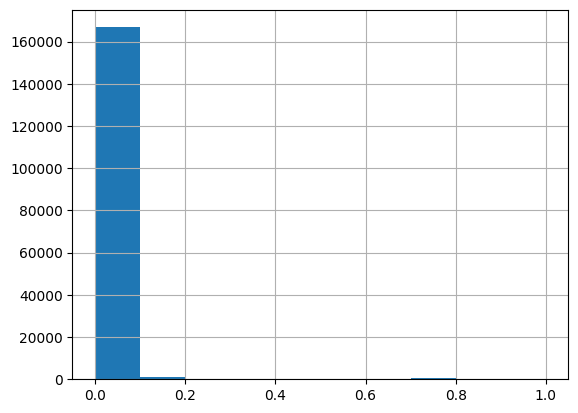

In [34]:
Geodata.LUCode.unique()
Geodata['predprobs'].hist()


In [136]:
Geodata.columns

Index(['index', 'OBJECTID', 'GEOID', 'ID', 'NAME', 'CITY', 'ST', 'ZIP',
       'SITUS_NO', 'SITUS',
       ...
       'NN4', 'NN5', 'WaterCoastDist', 'Risk', 'maxprobs', 'sdmaxLU',
       'sdmaxPr', 'maxindex', 'predLU', 'predprobs'],
      dtype='object', length=174)

In [68]:
def floodh_adjust( probi , floodx, lgwaterdist ):
    if probi >= 0.1:
        return 0.505721 + 0.271128 * floodx - 0.07561 * lgwaterdist
    elif probi < 0.1 and probi >= 0.04:
        return 1.882091 + 0.814026 * floodx - 0.17498  * lgwaterdist
    elif probi < 0.04 and probi >= 0.02:
        return 5.392617 + 0.924160 * floodx - 0.428017 * lgwaterdist
    elif probi < 0.02 and probi >= 0.01:
        return 8.518673 + 0.883055 * floodx - 0.567981 * lgwaterdist
    else:
        return 11.73178 + 0.759123 * floodx - 0.624486 * lgwaterdist

def cal_cate_diffs( dem, cates, logdisti):
    cateprobs       = np.array( [0.9, 0.96, 0.98, 0.99, 0.995]) 
    #cate_heights   = np.zeros( len(cateprobs) )
    cate_damages    = np.zeros( len(cateprobs) ) 
    cate_diffs      = np.zeros( len(cateprobs) ) 
    #slrH           = 0.0
    totalRisk       = 0
    cate_id         = 0
    for cateip in cateprobs:
        cate_heighti = ( mui - 1 * np.log( -1 * np.log( cateip ) )   * sigmai ) / 304.8
        if dem < cate_heighti and dem > 0:
            cate_floodi  = cate_heighti - dem  
        elif dem < 0 :
            cate_floodi  = cate_heighti
        else:
            cate_floodi  = 0
        cate_heightsi = floodh_adjust( cateip , cate_floodi, logdisti )
        if cates[cate_id] < 22 and cates[cate_id] > 0 :
            cate_diffs[cate_id] =  cates[cate_id] - cate_heightsi
        cate_id = cate_id +1
    return cate_diffs

cate1diff = []
cate2diff = []
cate3diff = []
cate4diff = []
cate5diff = []
for rowiter in Geodata.itertuples():
    cates_iteri = np.array( [rowiter.Cate1, rowiter.Cate2, rowiter.Cate3, rowiter.Cate4, rowiter.Cate5] )
    logdisti = np.log( rowiter.WaterCoastDist ) if rowiter.WaterCoastDist > 0 else 0
    diff_cate_i = cal_cate_diffs( rowiter.DEM , cates_iteri, logdisti )
    cate1diff.append( diff_cate_i[0] )
    cate2diff.append( diff_cate_i[1] )
    cate3diff.append( diff_cate_i[2] )
    cate4diff.append( diff_cate_i[3] )
    cate5diff.append( diff_cate_i[4] )

Geodata['cate1diff'] = cate1diff
Geodata['cate2diff'] = cate2diff
Geodata['cate3diff'] = cate3diff
Geodata['cate4diff'] = cate4diff
Geodata['cate5diff'] = cate5diff

Geodata.H_ft


0         15
1         15
2          0
3         15
4         15
          ..
170189    15
170190    15
170191    15
170192    15
170193    15
Name: H_ft, Length: 170194, dtype: int64

In [69]:

Geodata_select = Geodata[ [      'index',
    'TARGET_FID', 'VAL19TOT', 'VAL19LAND', 'VAL19IMP', 'LANDUSE', 'landCode', 
    'LUCode', 'poicode', 'poiclass', 'poiname', 'watercode', 'waterclass', 
    'watername', 'parkigcode', 'parkigclas', 'LUCode01re', 'LUCode06re', 
    'LUCode11re', 'LUCode15re', 'LUCode20re', 'ZipCode', 'policyCost', 'policyCount', 
    'elevationN', 'Content_Build_R', 'ACRES', 'Cate1', 'Cate2', 'Cate3', 'Cate4', 
    'Cate5', 'NumStories', 'FoundationType', 'FirstFloorHt', 'ContentCost',
    'BldgDamageFnID', 'CDDF_ID', 'YEARBUILT', 'Tract', 'Insurance', 'PopTot', 'TotalUnit', 
    'Mobile', 'vacant', 'MedHHInc', 'TotAge65', 'BelowHigh', 'BelPoverty', 'Minority', 
    'PopWhite', 'DEM', 'BeachDist', 'HealthDist', 'ParkDist', 'SchoolDist', 'CoastDist', 
    'WetlatDist', 'floodzones', 'buildDEM', 'H_ft', 'PArea', 'slope_mhw', 'logAccess', 'area_2', 
    'pararea', 'Risk', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'NEAR_DIST', 'NEA_DIST2',
    'WaterCoastDist', 'predprobs', 'predLU', 'cate1diff', 'cate2diff', 'cate3diff', 
    'cate4diff', 'cate5diff', 'geometry'] ] 

Geodata_select['NewGrowth2'] = Geodata_select.apply( lambda x :
                                      ChangeState( x['LUCode11re'], 
                                                  x['LUCode20re']) , axis=1)

Geodata_select['NewGrowth1'] = Geodata_select.apply( lambda x :
                                          ChangeState( x['LUCode01re'], 
                                                      x['LUCode11re']) , axis=1)



In [70]:

Geodata_select = gpd.GeoDataFrame( Geodata_select , geometry = 'geometry', crs="EPSG:4326")

write_dataframe( Geodata_select, path= r'../inputs/gis_data/Parcel_input_sce1_wo_ffh.shp',
                        driver='ESRI Shapefile')
write_dataframe( Geodata_select, path= r'../inputs/gis_data/Parcel_input_sce2_wo_ffh.shp',
                        driver='ESRI Shapefile')
write_dataframe( Geodata_select, path= r'../inputs/gis_data/Parcel_input_sce3_wo_ffh.shp',
                        driver='ESRI Shapefile')
write_dataframe( Geodata_select, path= r'../inputs/gis_data/Parcel_input_sce4_wo_ffh.shp',
                        driver='ESRI Shapefile')

#Parcel_input_sce4_wo_ffh

In [71]:
Geodata_select2 = Geodata_select.drop( ['geometry'] , axis=1)
Geodata_select2.to_csv( "/Users/yuhan/Desktop/Gradient_Boost_code/csv/sce1_wo_ffh.csv" )
Geodata_select2.to_csv( "/Users/yuhan/Desktop/Gradient_Boost_code/csv/sce2_wo_ffh.csv" )
Geodata_select2.to_csv( "/Users/yuhan/Desktop/Gradient_Boost_code/csv/sce3_wo_ffh.csv" )
Geodata_select2.to_csv( "/Users/yuhan/Desktop/Gradient_Boost_code/csv/sce4_wo_ffh.csv" )




<Axes: >

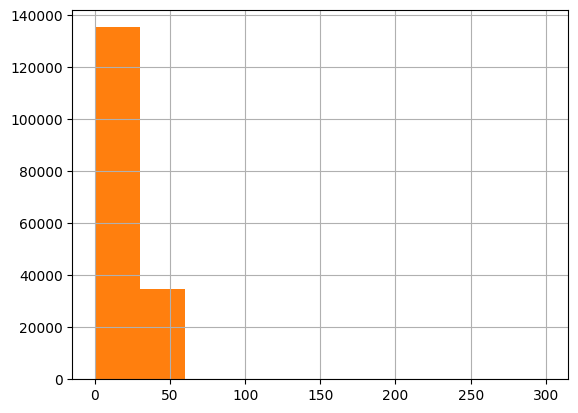

In [39]:
Geodata_select.FirstFloorHt.hist()
Geodata_select.H_ft.hist()

In [ ]:
'''
Call:
lm(formula = ParcelData1$Cate1 ~ ParcelData1$floodx1 + ParcelData1$logwaterdist)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.6193 -0.1479 -0.0356  0.0429  5.9569 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.505721   0.007121   71.02   <2e-16 ***
ParcelData1$floodx1       0.271128   0.001082  250.68   <2e-16 ***
ParcelData1$logwaterdist -0.075610   0.001136  -66.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7293 on 149749 degrees of freedom
Multiple R-squared:  0.424,	Adjusted R-squared:  0.424 
F-statistic: 5.512e+04 on 2 and 149749 DF,  p-value: < 2.2e-16
'''

''' 
Call:
lm(formula = ParcelData1$Cate2 ~ ParcelData1$floodx2 + ParcelData1$logwaterdist)

Residuals:
     Min       1Q   Median       3Q      Max 
-26.9103  -0.8218  -0.5977   1.1554  11.1886 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               1.882091   0.019336   97.33   <2e-16 ***
ParcelData1$floodx2       0.814026   0.002535  321.17   <2e-16 ***
ParcelData1$logwaterdist -0.174980   0.003059  -57.20   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.96 on 149749 degrees of freedom
Multiple R-squared:  0.5238,	Adjusted R-squared:  0.5238 
F-statistic: 8.237e+04 on 2 and 149749 DF,  p-value: < 2.2e-16
'''

''' 
Call:
lm(formula = ParcelData1$Cate3 ~ ParcelData1$floodx3 + ParcelData1$logwaterdist)

Residuals:
     Min       1Q   Median       3Q      Max 
-31.3609  -2.3412   0.1838   2.4660  14.2265 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               5.392617   0.032922  163.80   <2e-16 ***
ParcelData1$floodx3       0.924160   0.003776  244.73   <2e-16 ***
ParcelData1$logwaterdist -0.428017   0.005181  -82.61   <2e-16 ***
---


Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.324 on 149749 degrees of freedom
Multiple R-squared:  0.4328,	Adjusted R-squared:  0.4328 
F-statistic: 5.714e+04 on 2 and 149749 DF,  p-value: < 2.2e-16
'''

''' 
Call:
lm(formula = ParcelData1$Cate4 ~ ParcelData1$floodx4 + ParcelData1$logwaterdist)

Residuals:
    Min      1Q  Median      3Q     Max 
-30.779  -3.491   1.042   3.011  14.957 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               8.518673   0.042178  201.97   <2e-16 ***
ParcelData1$floodx4       0.883055   0.004159  212.32   <2e-16 ***
ParcelData1$logwaterdist -0.567981   0.006612  -85.91   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.254 on 149749 degrees of freedom
Multiple R-squared:  0.3808,	Adjusted R-squared:  0.3808 
F-statistic: 4.605e+04 on 2 and 149749 DF,  p-value: < 2.2e-16
'''

''' 
Call:
lm(formula = ParcelData1$Cate5 ~ ParcelData1$floodx5 + ParcelData1$logwaterdist)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.008  -2.636   1.446   3.319  13.585 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              11.731782   0.049035  239.25   <2e-16 ***
ParcelData1$floodx5       0.759123   0.004091  185.54   <2e-16 ***
ParcelData1$logwaterdist -0.624486   0.007665  -81.47   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.955 on 149749 degrees of freedom
Multiple R-squared:  0.3254,	Adjusted R-squared:  0.3254 
F-statistic: 3.611e+04 on 2 and 149749 DF,  p-value: < 2.2e-16
'''

In [ ]:
''' 
Call:
lm(formula = ParcelData1$DEM ~ ParcelData1$WaterCoastDist)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.523  -5.734  -1.136   4.895  65.734 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.092e+01  2.368e-02   461.0   <2e-16 ***
ParcelData1$WaterCoastDist 5.680e-03  2.338e-05   242.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.123 on 149750 degrees of freedom
Multiple R-squared:  0.2827,	Adjusted R-squared:  0.2827 
F-statistic: 5.902e+04 on 1 and 149750 DF,  p-value: < 2.2e-16
'''